In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# 위의 __future__ statement 는 파이썬 2.x 코드가 파이썬 3.x 처럼 작동하게 해줍니다. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns

In [5]:
pd.options.display.float_format = '{:.1f}'.format
pd.options.display.max_rows = 10
print('imported modules')

imported modules


In [11]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index))
# train_df = train_df.sample(frac=1)
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [12]:
# Z convert
train_df_norm = (train_df - train_df.mean())/train_df.std()
test_df_norm = (test_df - test_df.mean())/test_df.std()
print('Normalize the values')

Normalize the values


In [21]:
feature_columns = []

 We scaled all the columns, including latitude and longitude, into their Z scores. So, instead of picking a resolution in degrees, we're going to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to a full standard deviation. 

In [13]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2632,0.9,-1.0,-1.0,0.7,0.1,0.2,0.1,2.2,0.7
10238,-0.2,1.6,-1.6,-1.0,-1.0,-1.2,-1.3,-0.7,-0.2
8640,0.5,-0.7,0.5,-0.4,-0.6,-0.4,-0.5,0.4,0.1
14562,-1.3,1.1,0.4,-0.1,-0.3,-0.4,-0.2,0.4,0.0
9078,0.3,-0.1,0.7,-0.8,-0.8,-0.6,-0.7,-1.1,-1.3


In [15]:
resolution_in_Zs = 0.3

In [18]:
# Create a bucket feature column for latidude
latitude_as_a_numeric_column = tf.feature_column.numeric_column('latitude')
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])),
                                    resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

In [19]:
# Create a bucket feature column for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column('longitude')
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])),
                                     int(max(train_df_norm['longitude'])),
                                     resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

In [24]:
# Create a feature cross of latitude and longitude
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

In [25]:
# Represent median_income as a floating-point value
median_income = tf.feature_column.numeric_column('median_income')
feature_columns.append(median_income)

In [26]:
# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

In [28]:
# Convert the list of feature columns into a layer that will later be fed into the model
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [43]:
def plot_the_loss_curve(epochs, mse):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    
    plt.plot(epochs, mse, label='Loss')
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max()*1.03])
    plt.show()
    
print('Defined the plot_the_loss_curve function')

Defined the plot_the_loss_curve function


In [37]:
def create_model(my_learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    model.add(feature_layer)
    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

In [39]:
def train_model(model, dataset, epochs, batch_size, label_name):
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
    
    # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist['mean_squared_error']
    
    return epochs, rmse

print('Defined the create_model and train_model functions')

Defined the create_model and train_model functions


Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 4ms/step - loss: 1.0391 - mean_squared_error: 1.0391
Epoch 2/15
17/17 [==============================] - 0s 5ms/step - loss: 0.7015 - mean_squared_error: 0.7015
Epoch 3/15
17/17 [==============================] - 0s 4ms/step - loss: 0.5257 - mean_squared_error: 0.5257
Epoch 4/15
17/17 [==============================] - ETA: 0s - loss: 0.4356 - mean_squared_error: 0.43 - 0s 5ms/step - loss: 0.4266 - mean_squared_error: 0.4266
Epoch 5/15
17/17 [==============================] - 0s 6ms/step - loss: 0.3793 - mean_squared_error: 0.3793
Epoch 6/15
17/17 [==============================] - 0s 5ms/step - loss: 0.3638 - mean_squared_error: 0.3638
Epoch 7/15
17/17 [==============================] - 0s 6ms/step - loss: 0.3608 - mean_squared_error: 0.3608
Epoch 8/15
17/17 [==============================] - 0s 6ms/step - loss: 0.3602 - m

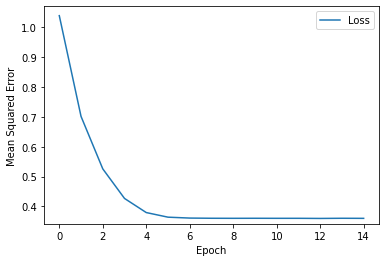

In [46]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

In [45]:
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 1s 5ms/step - loss: 0.3951 - mean_squared_error: 0.3951


[0.395093709230423, 0.395093709230423]